# What makes a song popular?
## An analysis of top songs from 2010-2019

In this analysis we will use a dataset of roughly ~470 songs to determine what makes a song popular.

Dataset: The dataset found on kaggle (https://www.kaggle.com/leonardopena/top-spotify-songs-from-20102019-by-year)

Goal: 
- There is a column in the data called "popularity" -- we will be using the data from 2010-2018 to train models and predict on the 2019 data. We will use popularity as the target variable. This is a continuous variable in the dataset.

Initial reactions:
- Break up popularity into 4 buckets. From Least Popular, Moderately Popular, Popular, Very Popular
- Use this ordinal target as well as the original continuous target
    - Do this for the sake of trying multiple methods

Methods:
- Try multiple linear regression
- Try multinominal logistic regression
- Other machine learning methods as we get further along

To begin: Import data. Start getting to know it a little bit better. Distributions of continuous variables and counts of categorical variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression 

    
import matplotlib.pyplot as plt

In [2]:
def inspect_rows(df, keep_column=[]):
    '''
    To find 0's in the dataset, but when you have columns where 0 entries are expected and allowed
    
    :param df: Data Frame where the data is located
    
    :param keep_column: If you expect one column to have a lot of 0's, 
    don't try to find rows where that column has 0's.
    
    :return new_df: A new dataframe where any rows that had more than 50% missing values are removed
    '''
    
    # Drop the column
    new_df = df.drop([keep_column], axis=1)
    
    # Search the rows in the DF for columns with 0
    rowsw0 = np.where(new_df == 0.0)[0]
    
    rowsw0 = list(dict.fromkeys(rowsw0))
    
    # Define short_df
    short_df = df.iloc[rowsw0,:]
    
    # Filter the dataframe to only give us where we have 0 values NOT in the acoustic column
    return short_df

In [3]:
def delete_rows(df, short_df):
    '''
    :param df: Takes the original dataframe of interest
    
    :param short_df: A shortened dataframe that contains rows that we might be concerned about
    
    NOTE: Change the `1` in the first line of the for loop to change to a different propotion
    
    :return new_df: A new dataframe where any rows that had more than 50% missing values are removed
    '''
    
    # Find the ratio of 0s in the row to not 0
    zeros = pd.Series(np.where(short_df == 0)[0]).value_counts()/pd.Series(np.where(short_df != 0)[0]).value_counts()

    # Drop the Entries
    for i in list(np.where(zeros>1)[0]):
        new_df = df.drop(short_df.iloc[i,].name)
        
    # Reset index for a continuous index
    new_df.reset_index()
    
    return new_df

In [4]:
df = pd.read_csv('top10s.csv', encoding='iso-8859-1').drop(['Unnamed: 0'],axis=1)

In [5]:
df.head()
#df = df.rename(columns={"top genre": "top_genre"})

,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
1,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
2,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80
3,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79
4,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78


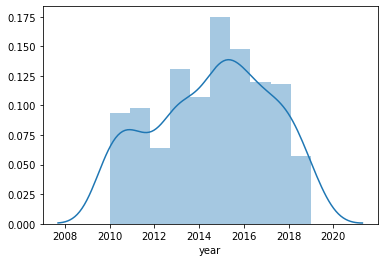

In [6]:
# How are the years distributed?
sns.distplot(df['year'], kde=True)

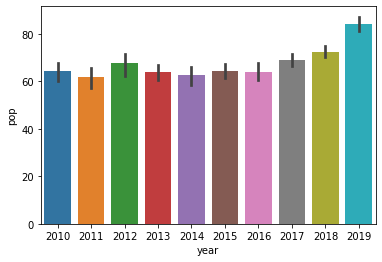

In [7]:
# How do the years get more popular as time goes on?
sns.barplot(x="year", y="pop", data=df)

General thought here, there is a gradual increase in popularity of songs overtime.

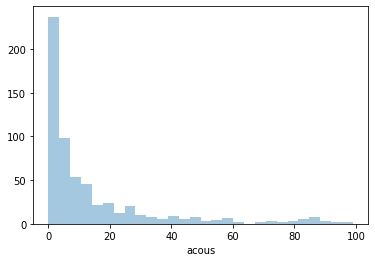

In [8]:
# How is acoustic distributed?
sns.distplot(df['acous'], kde=False)

Mostly 0. A few outliers closer to 100. But almost 0.

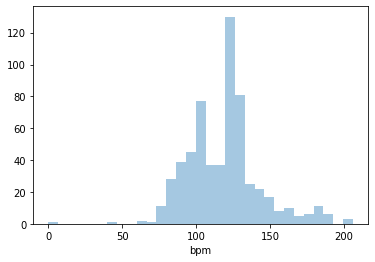

In [9]:
# How is bpm distributed?
sns.distplot(df['bpm'], kde=False)

In [10]:
# That's probably not right. Where is bpm near 0?
df[df['bpm'] < 20]

,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
442,Million Years Ago,Adele,british soul,2016,0,0,0,-60,0,0,227,0,0,0


Good business sense will tell us to delete this row. With the context of the problem, imputation does not make sense. We will drop this from the data.

## Data Cleaning

In [11]:
# Use the inspect rows function we defined at the beginning
short_df = inspect_rows(df, keep_column='acous')
# Million Years Ago looks not great. Let's drop that.

In [12]:
# Use the delete rows function we defined at the beginning
df = delete_rows(df, short_df)

In [13]:
# Check to see if the function did what it was supposed to
df.iloc[short_df.index,]
# We see that Million Years Ago is gone. And Shape of you has replaced it. Boom

,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
50,Hello,Martin Solveig,big room,2010,128,98,67,-3,10,45,191,1,3,0
138,Blow Me (One Last Kiss),P!nk,dance pop,2012,114,92,60,-3,25,75,256,0,4,0
267,Not a Bad Thing,Justin Timberlake,dance pop,2014,86,73,59,-6,38,46,266,27,6,0
362,L.A.LOVE (la la),Fergie,dance pop,2015,202,39,48,-8,26,27,193,2,9,0
443,Shape of You,Ed Sheeran,pop,2017,96,65,83,-3,9,93,234,58,8,87


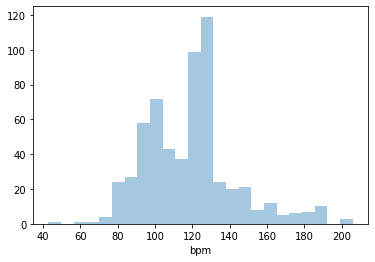

In [14]:
# Now, how is bpm distributed?
sns.distplot(df['bpm'], kde=False)
# Compare this to the original BPM histogram and it looks a lot better

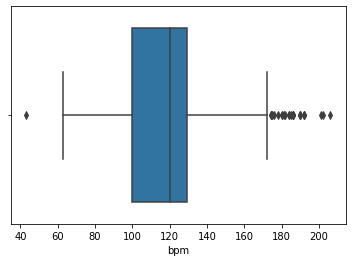

In [15]:
# Are there outliers?
sns.boxplot(df['bpm'])

BPM looks better now.

## ANOVA for Difference in Popularity between Years. Then another to see between Genre differences.

In [16]:
# Researchpy to look at the differences in the Popularity column by year
rp.summary_cont(df['pop'].groupby(df['year']))

,N,Mean,SD,SE,95% Conf.,Interval
year,,,,,,
2010,51,64.254902,13.227007,1.852152,60.588563,67.921241
2011,53,61.867925,16.058831,2.205850,57.503084,66.232765
2012,35,67.771429,14.528037,2.455686,62.888014,72.654843
2013,71,63.985915,12.864673,1.526756,60.972175,66.999656
2014,58,62.706897,15.545077,2.041169,58.671265,66.742528
2015,95,64.568421,14.352443,1.472530,61.666952,67.469890
2016,79,64.974684,14.614688,1.644281,61.731300,68.218067
2017,65,69.015385,10.982219,1.362177,66.324741,71.706028
2018,64,72.437500,9.870390,1.233799,70.000138,74.874862


In [17]:
# Conduct an ANOVA test to see if there is a significant difference in popularity across all the years in our data
stats.f_oneway(df['pop'][df['year'] == 2010], 
               df['pop'][df['year'] == 2011],
               df['pop'][df['year'] == 2012],
               df['pop'][df['year'] == 2013],
               df['pop'][df['year'] == 2014],
               df['pop'][df['year'] == 2015],
               df['pop'][df['year'] == 2016],
               df['pop'][df['year'] == 2017],
               df['pop'][df['year'] == 2018],
               df['pop'][df['year'] == 2019])

F_onewayResult(statistic=9.753603616201566, pvalue=5.556663482446503e-14)

What we learn from this F-statistic and p-value is that there IS a significant difference SOMEHWERE in our data. We don't know where exactly yet. But the difference is statistically significant.

## Next, use ANOVA with Statsmodels to get a little bit more robust information. This output looks a little bit more like SAS.

In [18]:
# Fit an Ordinary Least Squares model and retrieve the summary statistics
results = ols('pop ~ C(year)', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pop   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     9.754
Date:                Sat, 28 Mar 2020   Prob (F-statistic):           5.56e-14
Time:                        13:48:27   Log-Likelihood:                -2412.5
No. Observations:                 602   AIC:                             4845.
Df Residuals:                     592   BIC:                             4889.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          64.2549      1.879     34.190      0.000      60.564      67.946
C(year)[T.2011]    -2.3870      2.633     -0.907      0.365      -7.557       2.783
C(year)[T.2012]     3.5165      2.946      1.194      0.233      -2.269       9.302
C(year)[T.2013]    -0.2690      2.464     -0.109      0.913      -5.107       4.569
C(year)[T.2014]    -1.5480      2.576     -0.601      0.548      -6.608       3.512
C(year)[T.2015]     0.3135      2.330      0.135      0.893      -4.262       4.889
C(year)[T.2016]     0.7198      2.411      0.299      0.765      -4.015       5.455
C(year)[T.2017]     4.7605      2.511      1.896      0.058      -0.170       9.691
C(year)[T.2018]     8.1826      2.519      3.248      0.001       3.235      13.130
C(year)[T.2019]    20.0999      3.057      6.576      0.000      14.097      26.103
==============================================================================
Omnibus:                      187.846   Durbin-Watson:                   0.477
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              574.190
Skew:                          -1.498   Prob(JB):                    2.07e-125
Kurtosis:                       6.730   Cond. No.                         11.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see the F-statistic and p-value haven't changed from researchpy to Statsmodels.


## MAJOR ISSUE WITH INITIAL GOAL:
One potential issue here is if 2019 looks different then the data from before. If we train our model on 2010-2018 but then the 2019 data is statistically significantly different than that data, we begin to extrapolate and our model isn't doing as well as it can do.

### Avoiding Extrapolation?

## Using Statsmodels ANOVA to interpret differences

- We see the coefficients, those are saying how different the mean of each year is compared to the mean of 2010 (our control group here).


- Overall, this output is more useful to us because we are able to see the difference of each group compared to the 2010 group. Thus, we begin to find out where our significant differences are.


- We notice 2018 and 2019 are significantly different than 2010. The rest are not significantly different.

Next, we are looking for the overall model performance given by the ANOVA table.

In [19]:
aov_table = sm.stats.anova_lm(results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(year),15812.110539,9.0,9.753604,5.556663e-14
Residual,106636.022351,592.0,NaN,NaN


From the table, we see the sum of squares model (15,812) and sum of squares residual (106,636). This checks out for the R-Sq of .129 that we saw up above.

This means that 12.9% of the variance in the popularity is explained only by the year that the song was released in.
The more recent song, the more likely it is to be popular. This checks out with the bar charts we saw in our initial exploration.

# Modeling

## Regression Techniques

We learn from the above section that there are significant differences between the years. Although, the years aren't necessarily a key contributor to popularity. This shows us that we are on right track but need more info.

How can we get our model to explain more of the variance in popularity? Regression.

Although, where to start? We know that Simple Linear isn't the answer here because we have multiple variables and we want to use as much of the data as we can.

So that leads us to think about Multiple Regression techniques. 
- We need to decide on a regression technique
    - While also looking at variable importance. 
    - Only keeping the variables that provide us with relevant information. 
- Also, we should look at Multicollinearity. That will make our estimates unstable. We want to get rid of collinearity before model building.
    - Note that Ridge, Lasso, or Elastic Net Regression might allow us to make a regression model without explicity testing for multicollinearity but we will test for the sake of #learning.
- What about the categorical variables?
    - Let's create an indicator variable for them. Pandas Get Dummies might be a good way to encode these while maintaining the ability to know which column stands for which with those variables.

In [20]:
# First step, evaluating multicollinearity.
df.corr()

,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
year,1.000000,-0.101932,-0.225296,0.085272,-0.179094,-0.135352,-0.120510,-0.215458,0.102411,0.005789,0.249841
bpm,-0.101932,1.000000,0.095070,-0.176331,0.048817,0.072284,-0.002492,-0.029381,-0.121118,0.051148,-0.018128
nrgy,-0.225296,0.095070,1.000000,0.137382,0.663623,0.180074,0.400945,-0.145399,-0.576507,0.100965,-0.093693
dnce,0.085272,-0.176331,0.137382,1.000000,0.129737,-0.040512,0.494928,-0.179794,-0.250560,-0.037757,0.082394
dB,-0.179094,0.048817,0.663623,0.129737,1.000000,0.062574,0.342983,-0.168415,-0.349600,-0.061267,0.014400
live,-0.135352,0.072284,0.180074,-0.040512,0.062574,1.000000,0.015081,0.098645,-0.099917,0.141947,-0.087770
val,-0.120510,-0.002492,0.400945,0.494928,0.342983,0.015081,1.000000,-0.263175,-0.252936,0.118355,0.021746
dur,-0.215458,-0.029381,-0.145399,-0.179794,-0.168415,0.098645,-0.263175,1.000000,0.091917,0.054747,-0.105707
acous,0.102411,-0.121118,-0.576507,-0.250560,-0.349600,-0.099917,-0.252936,0.091917,1.000000,0.001483,0.021837
spch,0.005789,0.051148,0.100965,-0.037757,-0.061267,0.141947,0.118355,0.054747,0.001483,1.000000,-0.050956


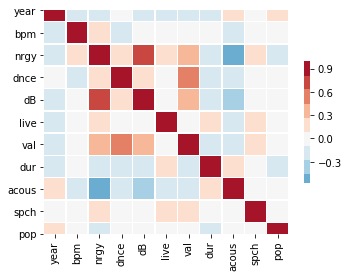

In [21]:
# This will show us the correlation structure.
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(5.5, 4.5))
cmap = sns.color_palette("RdBu_r", 11)

# Draw the heatmap
_ = sns.heatmap(corr, mask=None, cmap=cmap, vmax=1, center=0, square=True,
               linewidths=.5, cbar_kws={'shrink': .5})

At first glance this isnt too bad. It looks like acoustic/energy might be correlated (negatively), which makes sense.

Also, energy and dB seems to be related which makes sense as well.

Let's look for VIF > 10 to see if they need to be removed from the modeling process in some way.

In [22]:
# To calculate VIF, Python OLS requires a constant column. We will add that.

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Only use numeric data
regression = df._get_numeric_data()

# Add Constant
regression['Intercept'] = 1

# Calculate VIF
pd.Series([variance_inflation_factor(regression.values, i) 
               for i in range(regression.shape[1])], 
              index=regression.columns)

year              1.245260
bpm               1.081490
nrgy              2.711639
dnce              1.518635
dB                1.916149
live              1.080801
val               1.714105
dur               1.195465
acous             1.623068
spch              1.098760
pop               1.093605
Intercept    746364.709884
dtype: float64

## Small Discussion about VIF


Generally, a VIF above 10 means that term needs to be removed. Here, "nrgy" has a VIF of 2.71. There are other schools of thought that say above 2.5-3 is not good. Well, with "nrgy" right in that range, we will keep an eye on it.

We may run a model with nrgy and without nrgy and look at the tradeoffs. If we don't lose too much by removing it, there might be a case to remove it.

## Model Building: What do we consider?
- Multiple Linear Regression: Only using continuous, numeric predictors.


- Generalized Additive Model (GAM): They provide a modeling approach that combines powerful statistical learning with interpretability, smooth functions, and flexibility. Good use of OneHotEncoding before training a GAM. Also, GAMs allow for non-linear relationships. MLR and Generalized Linear Model (GLM) will assume linear relationships. For another notebook.

### Multiple Linear Regression

In [23]:
# Train/Test Split
msk = np.random.rand(len(df)) < 0.75
train = df[msk]
test = df[~msk]

## Multiple Regression
### Assumptions:
1. Linear Relationship

In [24]:
# Change many columns to numeric
cols = train.columns.drop(['title', 'artist', 'top genre'])
train[cols] = train[cols].apply(pd.to_numeric, errors='coerce')

# Change many columns to numeric
cols = test.columns.drop(['title', 'artist', 'top genre'])
test[cols] = test[cols].apply(pd.to_numeric, errors='coerce')

/Users/samlafell/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [25]:
# Subset Train to numeric columns
model_train = train.select_dtypes('number')

# Subset Test to numeric columns
model_test = test.select_dtypes('number')

In [26]:
# Subset to numeric columns
model_test = test.select_dtypes('number')

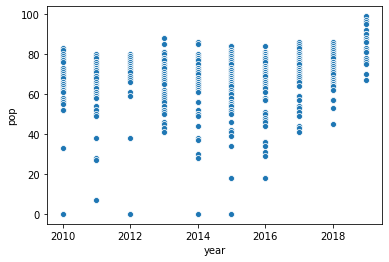

In [27]:
# Inspect relationships for linearity (change .iloc[:,0] to inspect different columns)
sns.scatterplot(x=model_train.iloc[:,0], y=model_train.iloc[:,-1])
plt.show()

None of the relationships are particarly strong when it comes to linearity, although, there don't appear to be transformations we need to apply to the data to make it take on another form to fit assumptions.

## Linear Regression using Stats Models (OLS)

In [28]:
from patsy import dmatrices

In [29]:
model_train.columns

Index(['year', 'bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous',
       'spch', 'pop'],
      dtype='object')

In [30]:
model_train['year'] = model_train['year'].astype(object)
model_test['year'] = model_test['year'].astype(object)

/Users/samlafell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/samlafell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
y_train, X_train = dmatrices('pop ~ year+ bpm+ nrgy+ dnce+ dB+ live+ val+ dur+ acous+ spch', data=model_train, return_type='dataframe')

In [32]:
y_test, X_test = dmatrices('pop ~ year+ bpm+ nrgy+ dnce+ dB+ live+ val+ dur+ acous+ spch', data=model_test, return_type='dataframe')

In [33]:
mod = sm.OLS(y_train, X_train)    # Describe model

In [34]:
res = mod.fit()       # Fit model

In [35]:
print(res.summary())   # Summarize model

                            OLS Regression Results                            
Dep. Variable:                    pop   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     3.638
Date:                Sat, 28 Mar 2020   Prob (F-statistic):           9.42e-07
Time:                        13:48:28   Log-Likelihood:                -1805.9
No. Observations:                 449   AIC:                             3650.
Df Residuals:                     430   BIC:                             3728.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       84.1433     10.639      7.909   

In [36]:
# Parameters from the model
#res.params

# Parameters from the model
#res.rsquared

# Test for Linearity
#print(sm.stats.linear_rainbow.__doc__)
#print(sm.stats.linear_rainbow(res))
#### All good ####

## One way to assess multicollinearity is to compute the condition number. Values over 20 are worrisome (see Greene 4.9). The first step is to normalize the independent variables to have unit length:

# Next Steps

 - High Condition Number is bad. Need to make sure we don't have multicollinearity.
     - Scale data?
 - Get prediction statistics.
 - Then, Drop variable from model, refit, repredict, store R2

In [37]:
ypred = res.predict(X_test)
mse = np.mean(y_test.iloc[:,0] - ypred)
rmse = np.sqrt(np.mean((y_test.iloc[:,0] - ypred)**2))

In [38]:
drop_var = res.pvalues.sort_values(ascending=False).index[0]

In [39]:
#X = X.drop(drop_var, axis=1)
mod = sm.OLS(y_train, X_train)    # Describe model
res = mod.fit()       # Fit model
print(res.summary())   # Summarize model
ypred = res.predict(X_test)
mse = np.mean((y_test.iloc[:,0] - ypred)**2)
rmse = np.sqrt(np.mean((y_test.iloc[:,0] - ypred)**2))
print(mse, rmse)

                            OLS Regression Results                            
Dep. Variable:                    pop   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     3.638
Date:                Sat, 28 Mar 2020   Prob (F-statistic):           9.42e-07
Time:                        13:48:28   Log-Likelihood:                -1805.9
No. Observations:                 449   AIC:                             3650.
Df Residuals:                     430   BIC:                             3728.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       84.1433     10.639      7.909   

In [49]:
import statsmodels.api as sm
def backwardElimination(train_df, test_df, sl):
    '''
    :param feature_cols: A numeric list of columns for features
    :param target_col: A single column for the target
    :param train_df: The training dataframe
    :param test_df: The test dataframe
    :param sl: Significance Level
    '''

    y_train, X_train = dmatrices('pop ~ year+ bpm+ nrgy+ dnce+ dB+ live+ val+ dur+ acous+ spch', data=train_df, return_type='dataframe')
    y_test, X_test = dmatrices('pop ~ year+ bpm+ nrgy+ dnce+ dB+ live+ val+ dur+ acous+ spch', data=test_df, return_type='dataframe')
    
    
    # Parts of function outside of any loop
    rmse_list = []
    mse_list = []
    numvar_list = []
    mae_list = []
    numVars = len(df.columns)
    
    for i in range(0, numVars):
        # How many vars in this model?
        numVar = len(X_train.columns)
        numvar_list.append(numVar)
    
        # Fit the model
        regressor_OLS = sm.OLS(y_train, X_train).fit()
        
        # What is the highest p-Value?
        maxVar = regressor_OLS.pvalues.sort_values(ascending=False)[0]
        
        # Get predictions with the current model
        ypred = regressor_OLS.predict(X_test)
        
        # MAE?
        mae_list.append(np.mean(abs(y_test.iloc[:,0] - ypred)))

        # What is the MSE of the current model
        mse_list.append(np.mean((y_test.iloc[:,0] - ypred)**2))
        
        # What is the RMSE of the current model
        rmse_list.append(np.sqrt(np.mean((y_test.iloc[:,0] - ypred)**2)))
        
        # If the Max p-Val is larger than our significance level, drop it from the competition
        if maxVar > sl:
            X_train = X_train.drop(regressor_OLS.pvalues.sort_values(ascending=False).index[0], axis=1)
            X_test = X_test.drop(regressor_OLS.pvalues.sort_values(ascending=False).index[0], axis=1)
            
    list_all = [numvar_list, rmse_list, mse_list, mae_list]
    
    print(regressor_OLS.summary())
    return list_all

In [50]:
iter_info = backwardElimination(train_df = model_train, test_df = model_test, sl = .01)

                            OLS Regression Results                            
Dep. Variable:                    pop   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     11.41
Date:                Sat, 28 Mar 2020   Prob (F-statistic):           2.27e-10
Time:                        13:53:46   Log-Likelihood:                -1810.5
No. Observations:                 449   AIC:                             3633.
Df Residuals:                     443   BIC:                             3658.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       69.8241      3.112     22.434   

Text(0.5, 0, 'Number of Variables')

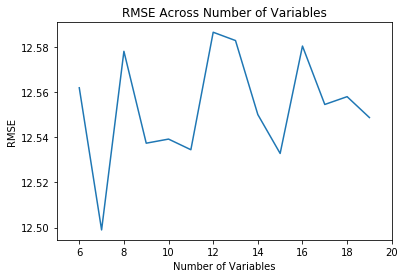

In [42]:
# Plot the RMSE Results
sns.lineplot(x=iter_info[0], y=iter_info[1])
plt.xlim(5, 20)
plt.title("RMSE Across Number of Variables") #Add plot title
plt.ylabel("RMSE") #Adjust the label of the y-axis
plt.xlabel("Number of Variables") #adjust x axis

Text(0.5, 0, 'Number of Variables')

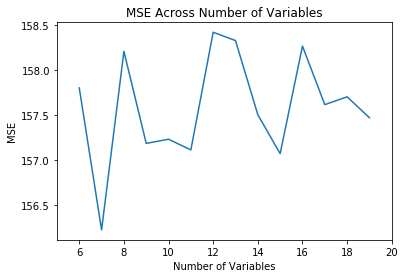

In [43]:
# Plot the MSE Results
sns.lineplot(x=iter_info[0], y=iter_info[2])
plt.xlim(5, 20)
plt.title("MSE Across Number of Variables") #Add plot title
plt.ylabel("MSE") #Adjust the label of the y-axis
plt.xlabel("Number of Variables") #adjust x axis

Text(0.5, 0, 'Number of Variables')

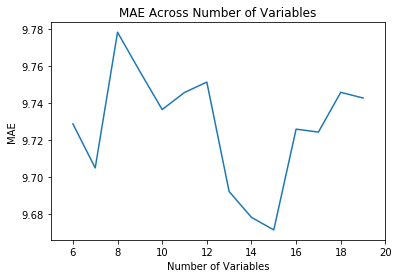

In [44]:
# Plot the MAE Results
sns.lineplot(x=iter_info[0], y=iter_info[3])
plt.xlim(5, 20)
plt.title("MAE Across Number of Variables") #Add plot title
plt.ylabel("MAE") #Adjust the label of the y-axis
plt.xlabel("Number of Variables") #adjust x axis

## That's it for this part of the notebook. We will try to build this analysis into a better look as to why our model isn't predicting as well as we would expect.

- R2 of 13.3% on Multiple Logistic Regression using Backward Selection at a Significance Level of .03 (sample size of ~400 for training and ~100 for test makes sense)

- Only a few levels of year and dB are showing as significant at this level. Can we explore some clustering techniques?

- Let's move into a notebook to explore clustering.

## Extra Code

In [45]:
# Might need this..

# Feature Scaling
"""from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)"""

'from sklearn.preprocessing import StandardScaler\nsc_X = StandardScaler()\nX_train = sc_X.fit_transform(X_train)\nX_test = sc_X.transform(X_test)\nsc_y = StandardScaler()\ny_train = sc_y.fit_transform(y_train)'

In [46]:
# Did it work?
X_train_imputed.columns = X_train.iloc[:, 3:].columns
# YES

X_train.iloc[:, :4].append(X_train_imputed)

NameError: name 'X_train_imputed' is not defined

In some brief data exploration, various data sets have had the Title/Artist/Genre columns with some weird characters. We want to just check over these three columns to see if they have any weird characters.

I'm defining that by being letters with accents (é, á, ó, ú, ë, ö, etc...), or maybe errors in the decoding process.

In [ ]:
# Use the string library to define a list of valid letters.
import string
alphabet = string.ascii_letters+string.punctuation

# What are our valid characters?
alphabet

# Do our columns have invalid entries?
# Col 1
df.title.str.strip(alphabet).astype(bool).any()

# Col 2
df.artist.str.strip(alphabet).astype(bool).any()

# Col 3
df.top_genre.str.strip(alphabet).astype(bool).any()

df.title.value_counts()

Oh what fun. Yes, all three columns have characters we wouldn't necessarily recognize. I will shelf this part of the analysis for later. There may be more important statistical tests to run first.
